Install dependencies

In [6]:
#!pip install mediapipe sklearn tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip list

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import tensorflow as tf
import os
import mediapipe as mp

In [4]:
mp_holistic = mp.solutions.holistic     #Holistic model
mp_drawing = mp.solutions.drawing_utils #Drawing utilities

In [5]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color conversion
    image.flags.writeable = False
    results = model.process(image)                 # Prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color reversion
    return image,results

In [35]:
#Draw faces,pose and hand connections
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    

In [39]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))

In [52]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)        

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        #Break loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [24]:
len(results.pose_landmarks.landmark)

33

In [43]:
draw_styled_landmarks(frame, results)

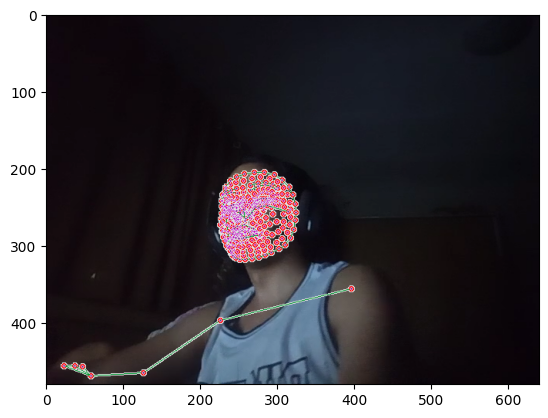

In [44]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [45]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    leftHand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rightHand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,leftHand,rightHand])

In [48]:
extract_keypoints(results).shape #Checking results

(1662,)

In [50]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_DATA')

# Actions that we try to detect
actions = np.array(['Ola', 'Obrigado','Eu te amo'])

# Thirty videos worth of data
no_sequences = 30

# Size in frames per video
sequence_length = 30


In [51]:
#Folder Creation with the actions on it
for action in actions:  
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass